In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('../chapter3/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

In [7]:
df.churn = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [10]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [11]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [47]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [48]:
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8055358410220014

Accuracy and dummy model

In [14]:
len(y_val)

1409

In [15]:
(y_val == churn_decision).sum()

1135

In [16]:
(y_val == churn_decision).sum() / len(y_val)

0.8055358410220014

In [25]:
from sklearn.metrics import accuracy_score

In [46]:
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f'{t:.2f} {score:.3f}')
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.607
0.15 0.663
0.20 0.705
0.25 0.735
0.30 0.759
0.35 0.768
0.40 0.781
0.45 0.791
0.50 0.806
0.55 0.801
0.60 0.798
0.65 0.785
0.70 0.767
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


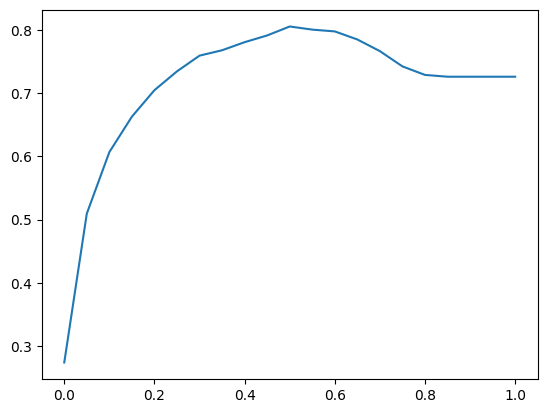

In [27]:
plt.plot(thresholds, scores)

Dummy model with threshold = 1.0 still has 73% percent accuracy !!!

<AxesSubplot:ylabel='count'>

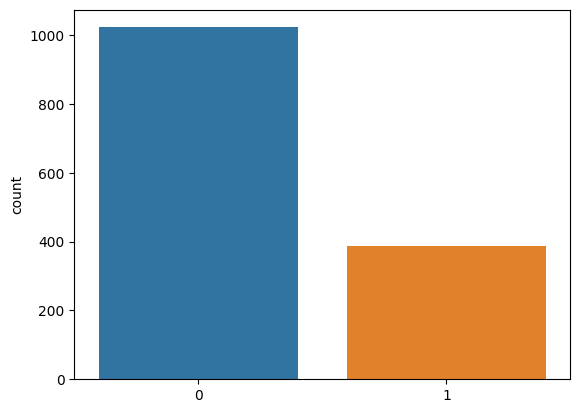

In [32]:
sns.countplot(x=y_val)

In [45]:
1 - y_val.mean()

0.7260468417317246

Accuracy is not good score because target is imbalanced

## Confusion matrix

In [33]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [36]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [37]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [38]:
tp, tn, fp, fn

(214, 921, 102, 172)

In [41]:
cm = np.array([[tn, fp], [fn, tp]])

In [42]:
cm

array([[921, 102],
       [172, 214]])

In [50]:
(cm / cm.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and recall

In [53]:
# accuracy
(tp + tn) / (tp + tn + fp + fn)

0.8055358410220014

In [55]:
# precision - fraction of correct positive predictions
tp / (tp + fp)

0.6772151898734177

In [56]:
# recall - fraction of correctly identified positive examples
tp / (tp + fn)

0.5544041450777202

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
print(confusion_matrix(y_val, y_pred >= 0.5))

[[921 102]
 [172 214]]


In [62]:
print(classification_report(y_val, y_pred >= 0.5))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.68      0.55      0.61       386

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



# ROC curves

TPR and FPR

In [64]:
# false positive rate
fpr = fp / (tn + fp)

In [65]:
# true positive rate = recall
tpr = tp / (fn + tp)

In [74]:
fpr, tpr

(0.0997, 0.5544)

In [73]:
%precision 4

'%.4f'

In [75]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))



In [80]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

In [81]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,534,20,489
20,0.2,338,368,48,655
30,0.3,293,246,93,777
40,0.4,253,176,133,847
50,0.5,214,102,172,921
60,0.6,152,51,234,972
70,0.7,69,12,317,1011
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [82]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

Text(0.5, 0, 'Threshold')

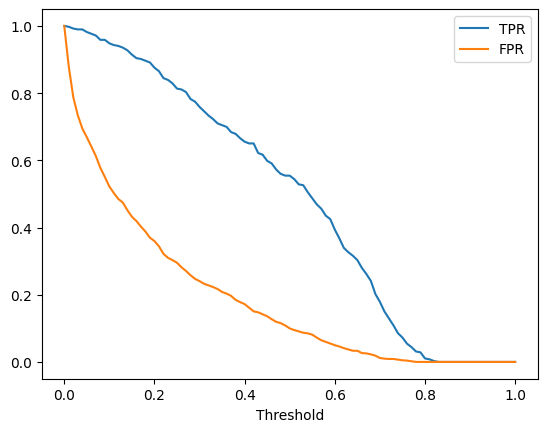

In [86]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')

Random model

In [87]:
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [88]:
accuracy_score(y_val, y_rand >= 0.5)

0.5067

In [89]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [90]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [91]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,351,929,35,94,0.909326,0.908113
20,0.2,319,826,67,197,0.826425,0.807429
30,0.3,274,722,112,301,0.709845,0.705767
40,0.4,240,601,146,422,0.621762,0.587488
50,0.5,196,505,190,518,0.507772,0.493646
60,0.6,162,407,224,616,0.419689,0.397849
70,0.7,128,312,258,711,0.331606,0.304985
80,0.8,83,203,303,820,0.215026,0.198436
90,0.9,45,106,341,917,0.116580,0.103617


Text(0.5, 0, 'Threshold')

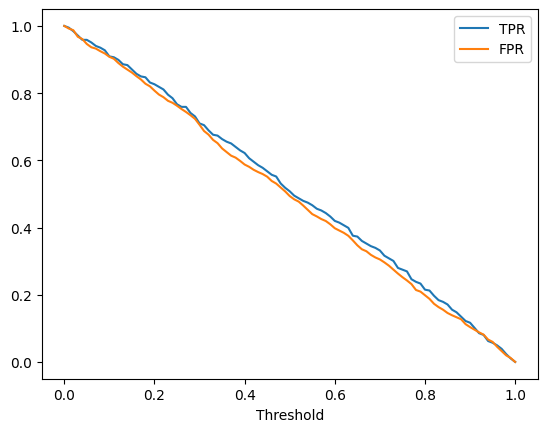

In [92]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')

Ideal model

In [93]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [94]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [96]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [97]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0000

In [98]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

Text(0.5, 0, 'Threshold')

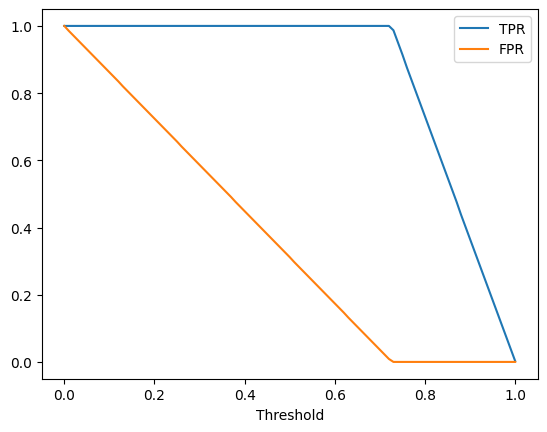

In [99]:


plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')

plt.legend()
plt.xlabel('Threshold')

Text(0.5, 0, 'Threshold')

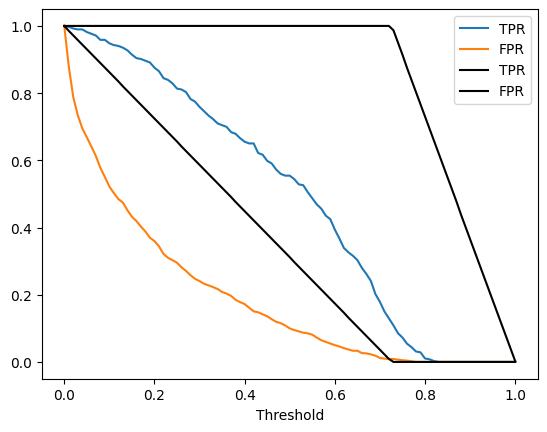

In [102]:

plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()
plt.xlabel('Threshold')

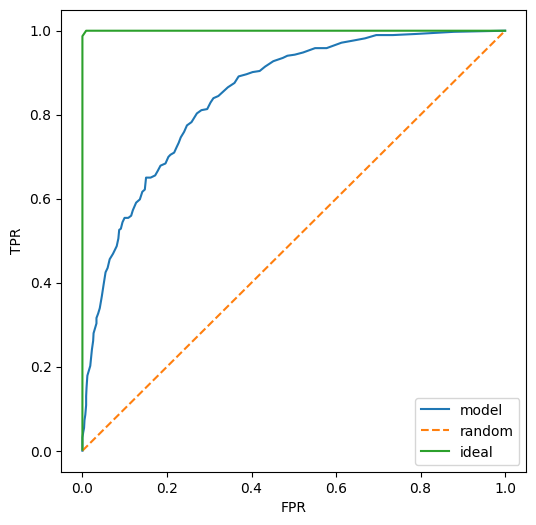

In [113]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

sklearn roc_curve

In [114]:
from sklearn.metrics import roc_curve

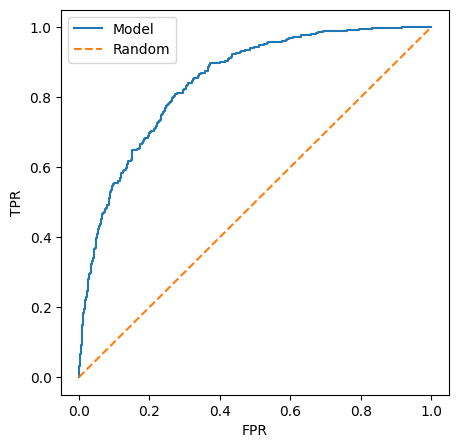

In [118]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC score

In [120]:
from sklearn.metrics import auc

In [121]:
auc(fpr, tpr)

0.8464

In [122]:
auc(df_scores.fpr, df_scores.tpr)

0.8462

In [123]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999

In [124]:
from sklearn.metrics import roc_auc_score

In [125]:
roc_auc_score(y_val, y_pred)

0.8464

interpretation of AUC as probability

In [126]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [127]:
import random

In [128]:
success = 0

for _ in range(10000):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / 10000

0.8451

the same but with *numpy*

In [137]:
n = 100000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).sum() / n

0.8477

## Cross-Validation

In [138]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [139]:
dv, model = train(df_train, y_train, C=0.001)

In [140]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [141]:
y_pred = predict(df_val, dv, model)

In [142]:
from sklearn.model_selection import KFold

In [157]:
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:

    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C={C:<5} {np.mean(scores):.4f} +- {np.std(scores):.4f}')


C=0.001 0.8248 +- 0.0089
C=0.01  0.8401 +- 0.0088
C=0.1   0.8413 +- 0.0075
C=0.5   0.8404 +- 0.0068
C=1     0.8404 +- 0.0086
C=5     0.8402 +- 0.0081
C=10    0.8412 +- 0.0077


Final model

In [159]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

roc_auc_score(y_test, y_pred)

0.8572